# Data engineer assessment - GORILLA
- Author: Francis Hofmans
- Date: 12/06/2023
- Duration: 3h15

## Import dependencies, load and prepare data

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import seaborn as sns

# Disabled, since certain parameters are overwritten on purpose
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Load the data (3 different tabs)
FILE = 'gorilla_test_data.xlsx'
XLS = pd.ExcelFile(FILE)
DF_ML = pd.read_excel(XLS, 'meter_list')
DF_F = pd.read_excel(XLS, 'forecast_table')
DF_R = pd.read_excel(XLS, 'rate_table')

In [3]:
# Replace nan values by infinity, for correct filtering of rates
DF_R.replace(np.nan, np.inf, inplace=True)
DF_R.head(5)

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,inf,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524


# Exercise 1: calculate transportation distribution charge

In [4]:
# Merge the rates with the meter list to get kwh information
df1 = DF_ML.merge(DF_R)

# Filter the rows for the correct min and max kwh
df1 = df1[(df1['aq_kwh'] >= df1['aq_min_kwh']) & (df1['aq_kwh'] < df1['aq_max_kwh'])]

In [5]:
# Forward fill the dataframe to get information for each day instead of periods of time
# First: create a dataframe containing all possible date and exit zone combinations
min_date, max_date = min(df1['date']), max(df1['date'])
df_dates = pd.date_range(min_date, max_date, freq='D')
df_dates = df_dates.to_frame(index=False, name='date')
df_dates['key'] = 1
DF_ML['key'] = 1
df_dates = df_dates.merge(DF_ML[['exit_zone', 'meter_id', 'key']], how='outer', on='key').drop(columns='key')
DF_ML = DF_ML.drop(columns='key')
#df_dates

In [6]:
# Second: merge this with the selected rates, and sort on exit zone and date
df1 = df_dates.merge(df1, how='left', on=['date', 'exit_zone', 'meter_id']).sort_values(by=['exit_zone', 'date'])

# Third forward fill the missing values, for each exit zone
cols = ['aq_kwh', 'aq_min_kwh', 'aq_max_kwh', 'rate_p_per_kwh']
df1.update(df1.groupby(['meter_id'])[cols].ffill())
#df1

In [7]:
# Merge with the forecasted information
df1['meter_id'] = df1['meter_id'].astype(int)
df1 = df1.merge(DF_F, on=['meter_id', 'date'], how='left').dropna()
df1.rename(columns={'kwh': 'forecast_kwh'}, inplace=True)

# Calculate the daily charge
df1['daily_charge'] = df1['rate_p_per_kwh'] * df1['forecast_kwh']
#df1

In [8]:
# Check if findings are in line with the given examples
check1 = df1[(df1['date'] == pd.to_datetime('2020-06-01')) & (df1['meter_id'] == 14676236)]
check1 = check1.iloc[0]['daily_charge'].round(5)
assert check1 == 5.85317

check2 = df1[(df1['date'] == pd.to_datetime('2022-02-27')) & (df1['meter_id'] == 14676236)]
check2 = check2.iloc[0]['daily_charge'].round(5)
assert check2 == 14.70528

In [9]:
# Sum per meter and convert to pounds
df1 = 0.01 * df1[['meter_id', 'daily_charge']].groupby('meter_id').sum().rename(columns={'daily_charge': 'Total Cost (£)'})
#df1

In [10]:
# Calculate the total consumption per meter
# First: select those rows that are within the date period
mask = (DF_F['date'] >= min_date) & (DF_F['date'] <= max_date)
_df = DF_F.loc[mask]
_df = _df[['meter_id', 'kwh']].groupby('meter_id').sum().rename(columns={'kwh': 'Total Estimated Consumption (kwh)'})

# Second: merge with the previously calculated dataframe
df1 = df1.merge(_df, on='meter_id').round(2)
df1

,Total Cost (£),Total Estimated Consumption (kwh)
meter_id,,
14676236,100.15,28978.0
34509937,275.49,78324.0
50264822,731.24,265667.0
88357331,1433.16,484399.0


# Exercise 2: list of random meters

In [11]:
valid_exit_zones = DF_R['exit_zone'].drop_duplicates().to_list()
print(*valid_exit_zones)

EA1 EA2 EA3 EA4 EM1 EM2 EM3 EM4 LC LO LS LT LW NE1 NE2 NE3 NO1 NO2 NT1 NT2 NT3 NW1 NW2 SC1 SC2 SC4 SE1 SE2 SO1 SO2 SW1 SW2 SW3 WA1 WA2 WM1 WM2 WM3


In [12]:
def create_random_meters(n: int):
    """
    Function that creates n random meters in the same format as the table provided in the excel sheet.
    Returns a dataframe with 3 columns: meter_id, aq_kwh, exit_zone.
    n: the number of meters to create
    """
    # Create the random meter ids, sample is used to avoid duplicates
    random_meter_ids = random.sample(range(10000000, 99999999), k=n)

    # Create the random annual quantities
    random_aqs = random.choices(range(0, 1000000), k=n)

    # Get random exit zones, sample is used to avoid duplicates
    random_exit_zones = random.sample(valid_exit_zones, k=n)

    dict = {'meter_id': random_meter_ids, 'aq_kwh': random_aqs, 'exit_zone': random_exit_zones}         
    return pd.DataFrame(dict)

n = random.randint(1, len(valid_exit_zones))
print(n, 'random meters are created')

df2 = create_random_meters(n)
df2

18 random meters are created


,meter_id,aq_kwh,exit_zone
0,45521707,339114,SW2
1,99445816,370177,NW2
2,55770768,309872,SO2
3,80704720,84153,LO
4,41487118,820869,NO1
5,37003062,5467,SC1
6,76220018,400889,SC4
7,34319077,858866,SW3
8,42269104,490485,SO1
9,40521266,669742,LC


# Exercise 3: Generate mock consumption data

In [13]:
def create_mock_consumption_data(df_meters, start_date: str, duration: int):
    """
    Function that generates random mock constumption data for given meters, start date and duration.
    Returns a dataframe containing a rate for each meter for each day within the time period.
    df_meters: pandas dataframe containing a column with unique meter_ids
    start_data: 'YYYY-MM-DD': the start date for which data will be generated
    duration: the number of days for which data will be generated
    """
    # Create the dates
    start_date = pd.to_datetime(start_date)
    df_dates = pd.date_range(start_date, periods=duration).to_frame(index=False, name='date')

    # Calculate the number of rates that are needed
    n = len(df_meters) * duration

    # Get random rates
    random_rates = random.choices(range(int(min(DF_F['kwh'])), int(max(DF_F['kwh']))), k=n)
    random_rates += np.random.sample(n) # Numpy is used to get random floats between 0 and 1

    # Combine into one dataframe
    _df = df_meters[['meter_id']]
    df_dates['key'] = 1
    _df['key'] = 1
    _df = df_dates.merge(_df[['meter_id', 'key']], how='outer', on='key').drop(columns='key')

    _df['kwh'] = random_rates
    
    return _df

df_meters = df2.copy()
start_date = '2021-01-01'
duration = 200

df3 = create_mock_consumption_data(df_meters, start_date, duration)
df3

,date,meter_id,kwh
0,2021-01-01,45521707,131.479401
1,2021-01-01,99445816,320.938416
2,2021-01-01,55770768,797.042400
3,2021-01-01,80704720,849.393946
4,2021-01-01,41487118,462.252756
...,...,...,...
3595,2021-07-19,37602837,895.024963
3596,2021-07-19,99154812,1075.573663
3597,2021-07-19,47817264,564.402022
3598,2021-07-19,70104732,432.159919


# Exercise 4: Calculate transportation cost table

In [14]:
def get_transportation_cost_table(df_meters, df_consumption_forecast):
    # Merge the rates with the meter list to get kwh information
    _df = df_meters.merge(DF_R, on='exit_zone')

    # Filter the rows for the correct min and max kwh
    _df = _df[(_df['aq_kwh'] >= _df['aq_min_kwh']) & (_df['aq_kwh'] < _df['aq_max_kwh'])]

    # Forward fill the dataframe to get information for each day instead of periods of time
    # First: create a dataframe containing all possible date and exit zone combinations
    min_date, max_date = min(_df['date']), max(_df['date'])
    df_dates = pd.date_range(min_date, max_date, freq='D')
    df_dates = df_dates.to_frame(index=False, name='date')
    df_dates['key'] = 1
    df_meters['key'] = 1
    df_dates = df_dates.merge(df_meters[['exit_zone', 'meter_id', 'key']], how='outer', on='key').drop(columns='key')
    df_meters = df_meters.drop(columns='key')

    # Second: merge this with the selected rates, and sort on exit zone and date
    _df = df_dates.merge(_df, how='left', on=['date', 'exit_zone', 'meter_id']).sort_values(by=['exit_zone', 'date'])

    # Third forward fill the missing values, for each exit zone
    cols = ['aq_kwh', 'aq_min_kwh', 'aq_max_kwh', 'rate_p_per_kwh']
    _df.update(_df.groupby(['meter_id'])[cols].ffill())

    # Merge with the forecasted information
    _df['meter_id'] = _df['meter_id'].astype(int)
    _df = _df.merge(df_consumption_forecast, on=['meter_id', 'date'], how='left').dropna()
    _df.rename(columns={'kwh': 'forecast_kwh'}, inplace=True)

    # Calculate the daily charge
    _df['daily_charge'] = _df['rate_p_per_kwh'] * _df['forecast_kwh']

    # Sum per meter and convert to pounds
    _df = 0.01 * _df[['meter_id', 'daily_charge']].groupby('meter_id').sum().rename(columns={'daily_charge': 'Total Cost (£)'})
    
    # Calculate the total consumption per meter
    # First: select those rows that are within the date period
    mask = (df_consumption_forecast['date'] >= min_date) & (df_consumption_forecast['date'] <= max_date)
    _df_c = df_consumption_forecast.loc[mask]
    _df_c = _df_c[['meter_id', 'kwh']].groupby('meter_id').sum().rename(columns={'kwh': 'Total Estimated Consumption (kwh)'})

    # Second: merge with the previously calculated dataframe
    _df = _df.merge(_df_c, on='meter_id').round(2)
    return _df


df_meters = create_random_meters(30)
df_consumption_forecast = create_mock_consumption_data(df_meters, '2021-01-01', 10000)

df4 = get_transportation_cost_table(df_meters, df_consumption_forecast)
df4

,Total Cost (£),Total Estimated Consumption (kwh)
meter_id,,
11420049,4071.43,804857.95
13385044,4166.40,803751.53
17528503,3166.69,792316.32
17662708,2868.04,814954.85
25112027,3198.99,782457.49
25774385,2962.99,802703.50
29019902,3341.53,810949.09
31893427,2550.10,813519.84
35276568,2634.36,806185.83


# Benchmark
- Takes a couple of seconds for a frequency of 365 days
- Takes around a minute for a frequency of 30 days

In [15]:
frequency = 30 #days

In [16]:
# Length of meters
nb_meters = [i for i in range(1, len(valid_exit_zones))]

# Duration (nb_days)
# Takes a couple of seconds for a frequency of 365 days
# Takes around a minute for a frequency of 30 days
nb_durations = [i for i in range(1, (max_date - min_date).days, frequency)]

# Get the 
start_date = min(DF_R['date'])

print('Start_date:', start_date)
print('Amount of durations to benchmark:', len(nb_durations))
print('Amount of meters to benchmark:', len(nb_meters))

df_meters = pd.DataFrame(nb_meters, columns=['nb_meters'])
df_durations = pd.DataFrame(nb_durations, columns=['nb_days'])
df_meters['key'] = 1
df_durations['key'] = 1
df4 = df_meters.merge(df_durations, how='outer', on='key').drop(columns='key')

# Apply the calculation function to each row and get the duration of the process
def apply_transportation_cost_function(row):
    nb_meters = row[0]
    nb_days = row[1]

    df_meters = create_random_meters(nb_meters)
    df_consumption_forecast = create_mock_consumption_data(df_meters, start_date, nb_days)

    # Calculate time difference
    t0 = datetime.datetime.now()
    df4 = get_transportation_cost_table(df_meters, df_consumption_forecast)
    t1 = datetime.datetime.now()
    t = t1 - t0
    
    return t.microseconds

df4['duration (microseconds)'] = df4.apply(apply_transportation_cost_function, axis=1)
#df4


Start_date: 2020-04-01 00:00:00
Amount of durations to benchmark: 55
Amount of meters to benchmark: 37


<Axes: xlabel='nb_days', ylabel='nb_meters'>

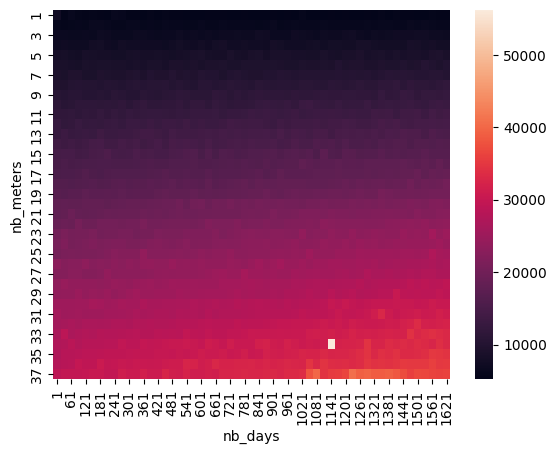

In [17]:
# Create a heatmap plot, showing the duration of running different experiments with different combinations of the number of meters and number of days
df_plot = df4.pivot(index='nb_meters', columns='nb_days', values='duration (microseconds)')

sns.heatmap(df_plot, annot=False)

# Exercise 5: Conclusion benchmark
- Overall this runs quite fast, with the majority of benchmarks below 4/100th of a second.
- Increasing the number of days has little to no effect on the processing duration.
- Increasing the number of meters on the other hand has a linear increase in processing duration. This can become quite a problem. Currently there are only 37 meters taken into account, while in reality I assume there will be much more.
- A possible solution is to eliminate the amount of redundant information in the table. Currently the forward fill method is used to create a single line for each day, while in the original rates table, there is a single line for a six month period. Structuring the tables differently should make it possible to retrieve the rate_p_per_kwh for a certain period of time and multiplying this with all rows that are within this period in the forecasting table. That should reduce the duration, since it has to retrieve only one value per 6 months instead of retrieving the same value for each day within each 6 month period.